# GMM method analysis and final errors for DS-IA

In [ ]:
# Set to true if on COLAB
USING_COLAB = False

In [ ]:
# If using google colab
if USING_COLAB:
    from google.colab import drive
    drive.mount("/content/gdrive")
    import os
    # Set to the folder the repo was cloned
    os.chdir("/content/gdrive/MyDrive/Colab Notebooks/STRIKE_YOLO_DRIVE/STRIKE_YOLO")

In [ ]:
! pip install .

In [ ]:
NOTEBOOK_CONFIG = {
    "IMG_LENGTH": 0.377,
    "IMG_WIDTH": 0.143,
    "IMG_XDIM": 143,
    "IMG_YDIM": 377,
    "labels_type": "Labelsv0_detect",
    "task": "detect",
    "model_name": "YOLOv0_detect",
}

In [ ]:
# Sample image
n_image = 109
image_path = f"docs/Data/Images/gaussian_{n_image}.png"
label_path = f"docs/Data/{NOTEBOOK_CONFIG['labels_type']}/gaussian_{n_image}.txt"

In [ ]:
import os
import pandas as pd
import numpy as np

from datetime import datetime

from matplotlib import pyplot as plt

In [ ]:
from scipy.ndimage import laplace
import scipy.io

from skimage.feature import peak_local_max
from adjustText import adjust_text

In [ ]:
from PIL import Image

# Load modules

In [ ]:
from helpers.auxiliary_functions import (
    generate_grid,
    parameters_extract,
    checkpoint_error,
)
from helpers.aux_plotter import plot_boxes_gmm, gaussians_labelled, plot_grayscale
from helpers.gaussian_estimation import sum_gaussians, compute_mse

from pipelines.pipelines import ppl_fit_gaussians, ppl_error_estimation

# Data from CNR

## Load
- Real size of the tile is roughly equal to 2 pixel / mm

In [ ]:
# Load 400 gaussians
mat = scipy.io.loadmat("docs/Data/db_80beam.mat")
print(mat.keys())

dict_keys(['__header__', '__version__', '__globals__', 'F_data', 'Fit_flux', 'beta'])


In [ ]:
# Generate GRID
x, y = generate_grid(
    (0, NOTEBOOK_CONFIG["IMG_WIDTH"]),
    (0, NOTEBOOK_CONFIG["IMG_LENGTH"]),
    NOTEBOOK_CONFIG["IMG_XDIM"],
    NOTEBOOK_CONFIG["IMG_YDIM"],
)

## Box of the gaussians - using dispersion_x and dispersion_y (from true parameters)

In [ ]:
# Load data
# Image - z intensities
image = [x, y, mat["F_data"][:, :, n_image]]

# Parameters extraction
amplitude, xs, ys, dispersion_x, dispersion_y = parameters_extract(
    mat["Fit_flux"], n_image
)

In [ ]:
# Structure covariances
covariances = [
    np.diag(cov)
    for cov in zip((dispersion_x / np.sqrt(2)) ** 2, (dispersion_y / np.sqrt(2)) ** 2)
]

Number of indentifiable Gaussians (center in the image): 78


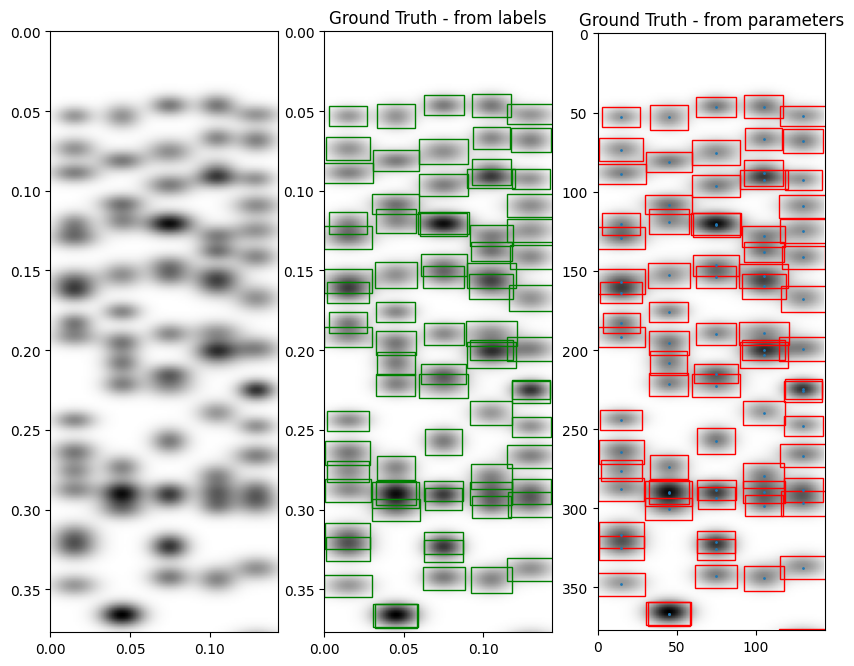

In [ ]:
# Open the image file
im = Image.open(image_path)

# Create figure and axes
fig, axs = plt.subplots(1, 3, figsize=(10, 10))

# Display the image
axs[2].imshow(im)
plot_boxes_gmm(means=list(zip(xs, ys)), covariances=covariances, ax=axs[2], beta=3)
axs[2].set_title("Ground Truth - from parameters")
axs[2].scatter(xs * 1000, ys * 1000, s=1)

# Labelling
x, y, z = gaussians_labelled(
    image_path, label_path, axs[1], task=NOTEBOOK_CONFIG["task"], colorbar=False
)
axs[1].set_title("Ground Truth - from labels")

# Image
plot_grayscale(x, y, z, colorbar=False, ax=axs[0])

axs[0].invert_yaxis()
axs[1].invert_yaxis()

axs[2].set_xlim(0, NOTEBOOK_CONFIG["IMG_XDIM"])
axs[2].set_ylim(0, NOTEBOOK_CONFIG["IMG_YDIM"])
axs[2].invert_yaxis()

for ax in axs:
    ax.xaxis.label.set_text("")
    ax.yaxis.label.set_text("")

# [ESTIMATION PART I]
- Images: 0 - 200 (Gaussians with only overlapping in y-direction)
  - All amplitudes are higher around 1.5E6 (250%)
  - x center coincides with beta xs
  - y center It has some Gaussians deslocated to up and other to down around 0.01 in y direction
  - dispersion in x Higher dispersion in x directions around 0.003 (40%)
  - dispersion in y Higher dispersion in y direction around 0.002 (40%)


## [ESTIMATION] Pipeline ppl_SCIKIT_GMM
- Processing using Scikit-image library
- Mean and covariances from GMM

In [ ]:
# Load data
# Image - z intensities
image = [x, y, mat["F_data"][:, :, n_image]]

# Parameters extraction
amplitude, xs, ys, dispersion_x, dispersion_y = parameters_extract(
    mat["Fit_flux"], n_image
)

### Centers estimation

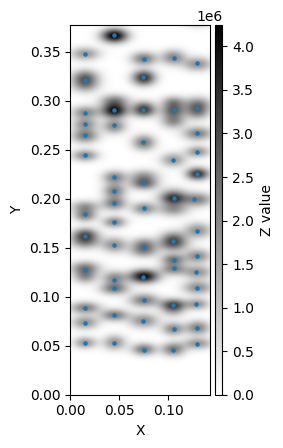

In [ ]:
# Find local maxima coordinates
coordinates = peak_local_max(image[2], min_distance=1)

# 2D plot in grayscale - selected image for initial development
fig, ax = plt.subplots()
plot_grayscale(x, y, image[2], ax)
ax.scatter(image[0][0, [coordinates[:, 1]]], image[1][coordinates[:, 0], 0], s=5)

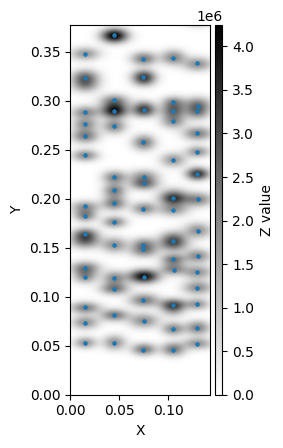

In [ ]:
# Find local maxima coordinates
z_laplace = laplace(image[2])
z_laplace[np.nonzero(z_laplace >= 0)] = 0
coordinates = peak_local_max(-1 * z_laplace, min_distance=1)

# 2D plot in grayscale - selected image for initial development
fig, ax = plt.subplots()
plot_grayscale(x, y, image[2], ax)
ax.scatter(image[0][0, [coordinates[:, 1]]], image[1][coordinates[:, 0], 0], s=5)

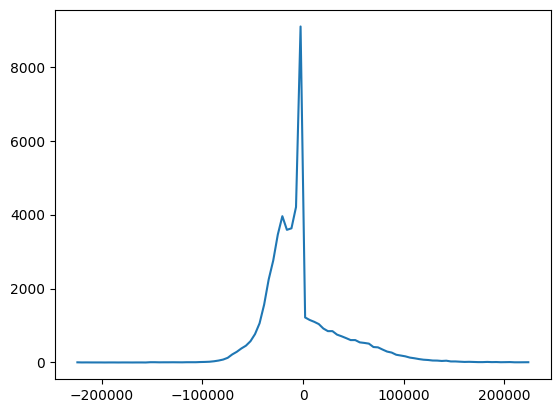

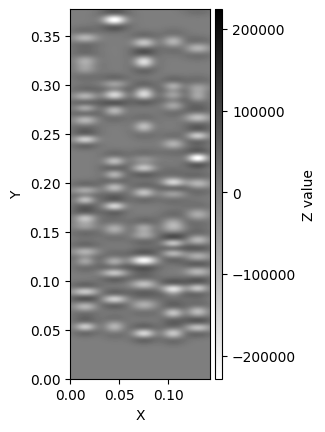

In [ ]:
# Thresholding laplacian
# histogram of values
histogram, bin_edges = np.histogram(-1 * laplace(image[2]), bins=100)

fig, ax = plt.subplots()
ax.plot(bin_edges[0:-1], histogram)

fig, ax = plt.subplots()
plot_grayscale(x, y, laplace(image[2]), ax)

estimate_parameters_gmm executed in 1.4172110557556152 seconds
ppl_fit_gaussians executed in 1.7592580318450928 seconds


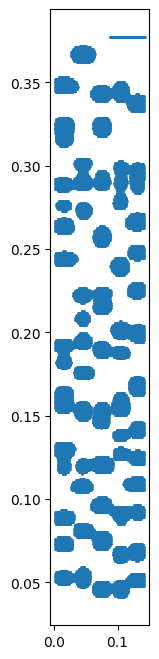

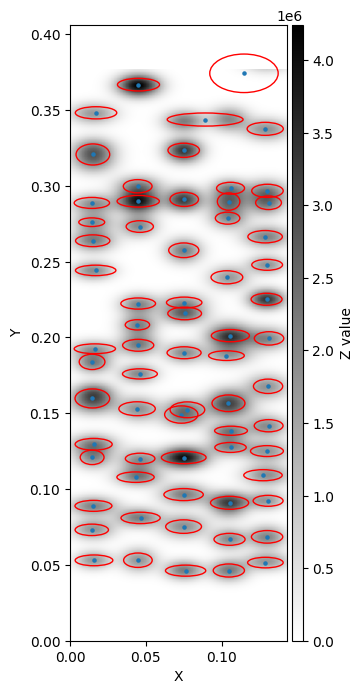

In [ ]:
# Estimate Gaussian - Final prediction
(means, covariances, angles, amplitudes) = ppl_fit_gaussians(
    image,
    means_init="laplace",
    peak_method="laplace",
    em_iterations=1000,
    covariance_gaussians_type="diag",
    n_gaussians=None,
    image_ranges=[
        (0, NOTEBOOK_CONFIG["IMG_WIDTH"]),
        (0, NOTEBOOK_CONFIG["IMG_LENGTH"]),
    ],
    image_size=[NOTEBOOK_CONFIG["IMG_XDIM"], NOTEBOOK_CONFIG["IMG_YDIM"]],
    fig_size=(10, 8),
    plot=True,
    plot_points=True,
)

Number of indentifiable Gaussians (center in the image): 78


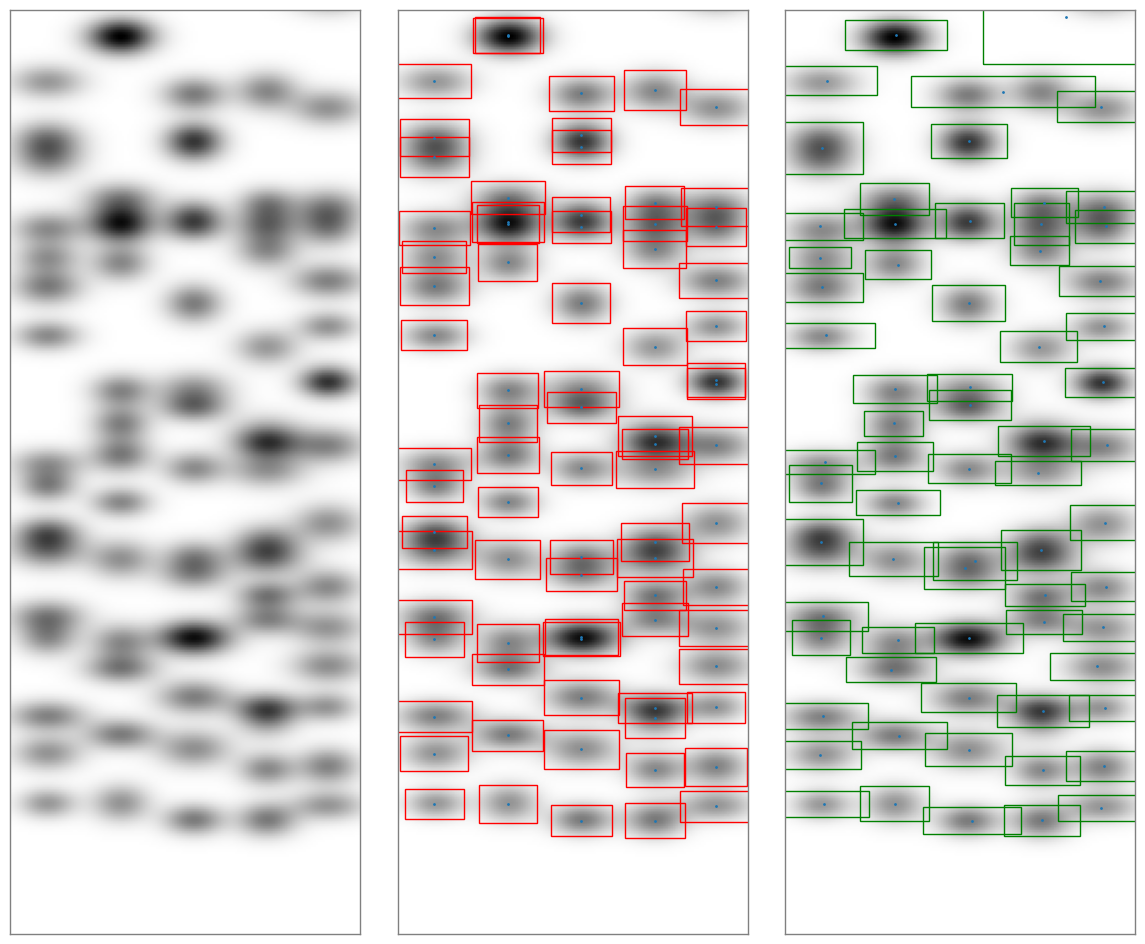

In [ ]:
# Open the image file
im = Image.open(image_path)

# Create figure and axes
fig, axs = plt.subplots(1, 3, figsize=(15, 12))

# Display the image and plot predicted centers
axs[2].imshow(im)
plot_boxes_gmm(means=means, covariances=covariances, ax=axs[2], beta=3, edge_color="g")
axs[2].set_ylim(ax.get_ylim()[::-1])
axs[2].scatter(means[:, 0] * 1000, means[:, 1] * 1000, s=1)
# axs[2].axis('off')
axs[2].set_xlim(0, NOTEBOOK_CONFIG["IMG_XDIM"])
axs[2].set_ylim(0, NOTEBOOK_CONFIG["IMG_YDIM"])

# axs[2].set_title("Prediction")

# Labelling
x, y, z = gaussians_labelled(
    image_path,
    label_path,
    axs[1],
    task=NOTEBOOK_CONFIG["task"],
    colorbar=False,
    plot_centers=True,
)
# axs[1].axis('off')
axs[1].set_xlim(0, NOTEBOOK_CONFIG["IMG_WIDTH"])
axs[1].set_ylim(0, NOTEBOOK_CONFIG["IMG_LENGTH"])
# axs[1].set_title("Ground Truth")

# Image
plot_grayscale(x, y, z, colorbar=False, ax=axs[0])
# axs[0].axis('off')
axs[0].set_xlim(0, NOTEBOOK_CONFIG["IMG_WIDTH"])
axs[0].set_ylim(0, NOTEBOOK_CONFIG["IMG_LENGTH"])


for ax in axs:
    ax.xaxis.label.set_text("")
    ax.yaxis.label.set_text("")

    ax.set_xticks([])
    ax.set_yticks([])
    # Change the color of the axis spines (borders)
    for spine in ax.spines.values():
        spine.set_edgecolor("gray")
        spine.set_linewidth(1)

plt.subplots_adjust(wspace=0)
plt.show()

### Error evaluation
- Dispersion_x in the mat file is equal to sqrt(2) * sigma_x, same for y direction

In [ ]:
# Get number of images that need to be evaluated - YOLO test set
images_test = os.listdir(
    f"docs/Models/{NOTEBOOK_CONFIG['model_name']}/datasets/test/images/"
)
eval_images = [
    int(i.split("_")[1].split(".")[0]) for i in images_test
]  # Use the same images of the test from YOLO

In [ ]:
print(eval_images)

[193, 121, 140, 186, 94, 113, 99, 184, 112, 176, 194, 109, 131, 70, 129, 79, 55, 148, 18, 53]


In [ ]:
# Iterate all images - GMM method
results = {
    "Image": [],
    "Number identified - gmm": [],
    "Number identifiable - gmm": [],
    "Percentage - gmm": [],
    "RMSE_cx - gmm": [],
    "RMSE_cy - gmm": [],
    "RMSE_c - gmm": [],
    "RMSE_sigmax - gmm": [],
    "RMSE_sigmay - gmm": [],
    "RMSE_sigma - gmm": [],
    "RMSE_amplitude - gmm": [],
    "MaxE_sigmax - gmm": [],
    "MaxE_sigmay - gmm": [],
    "MaxE_sigma - gmm": [],
    "RMSE_amplitude - gmm": [],
    "RMSEPixel - gmm": [],
}

for n_image in eval_images:
    eval_gaussian = ppl_error_estimation(
        n_image,
        mat,
        peak_method="laplace",
        estimation_method="gmm",
        covariance_gaussians_types="diag",
        return_percentage=True,
    )
    # Append values in the dictionary
    for key in results.keys():
        if key in eval_gaussian:
            results[key] += eval_gaussian[key]

estimate_parameters_gmm executed in 0.9056673049926758 seconds
ppl_fit_gaussians executed in 0.9480681419372559 seconds
covariances [[[    0.01317           0]
  [          0   0.0043973]]]
covariances true [[[    0.01214           0]
  [          0    0.007621]]]
estimate_parameters_gmm executed in 0.8623306751251221 seconds
ppl_fit_gaussians executed in 0.878237247467041 seconds
covariances [[[   0.010482           0]
  [          0    0.004549]]]
covariances true [[[   0.013846           0]
  [          0   0.0062577]]]
estimate_parameters_gmm executed in 0.8903529644012451 seconds
ppl_fit_gaussians executed in 0.907076358795166 seconds
covariances [[[   0.011242           0]
  [          0   0.0041981]]]
covariances true [[[   0.010988           0]
  [          0   0.0059603]]]
estimate_parameters_gmm executed in 2.9405324459075928 seconds
ppl_fit_gaussians executed in 2.9685633182525635 seconds
covariances [[[   0.014549           0]
  [          0   0.0040779]]]
covariances true 

In [ ]:
pd.DataFrame.from_dict(results).describe().round(2).loc[["mean", "std", "max"]].T

,mean,std,max
Image,120.20,50.49,194.00
Number identified - gmm,65.45,2.31,69.00
Number identifiable - gmm,78.60,0.75,80.00
Percentage - gmm,83.28,3.04,87.34
RMSE_cx - gmm,1.62,0.37,2.81
RMSE_cy - gmm,0.39,0.07,0.56
RMSE_c - gmm,1.67,0.37,2.83
RMSE_sigmax - gmm,16.32,2.08,21.89
RMSE_sigmay - gmm,39.13,1.40,41.68
RMSE_sigma - gmm,42.44,1.75,45.39


In [ ]:
pd.DataFrame.from_dict(results).round(2)

,Image,Number identified - gmm,Number identifiable - gmm,Percentage - gmm,RMSE_cx - gmm,RMSE_cy - gmm,RMSE_c - gmm,RMSE_sigmax - gmm,RMSE_sigmay - gmm,RMSE_sigma - gmm,RMSE_amplitude - gmm,MaxE_sigmax - gmm,MaxE_sigmay - gmm,MaxE_sigma - gmm,RMSEPixel - gmm
0,193,66,79,83.54,1.37,0.33,1.40,15.31,38.71,41.63,21.58,41.39,48.62,63.85,319736.75
1,121,65,78,83.33,1.89,0.34,1.92,15.47,40.10,42.98,20.58,38.85,99.61,106.92,340437.86
2,140,66,78,84.62,1.50,0.37,1.54,15.87,39.74,42.79,17.39,62.78,60.97,87.51,342588.32
3,186,67,77,87.01,1.86,0.56,1.95,19.99,40.02,44.74,18.35,261.41,229.05,347.57,357919.05
4,94,63,78,80.77,1.48,0.47,1.56,17.88,39.93,43.75,22.64,178.17,101.27,204.94,350032.75
5,113,64,79,81.01,1.53,0.38,1.57,15.61,38.22,41.28,23.08,41.90,51.32,66.26,399508.35
6,99,67,79,84.81,1.32,0.34,1.37,14.53,39.84,42.41,20.18,44.09,52.89,68.86,340120.98
7,184,69,79,87.34,1.83,0.30,1.85,15.10,40.30,43.04,15.78,44.03,128.66,135.99,333700.72
8,112,67,79,84.81,1.20,0.30,1.24,14.83,38.22,40.99,19.33,42.34,56.70,70.77,339451.47
9,176,68,79,86.08,1.27,0.35,1.31,17.60,38.72,42.54,18.02,40.34,51.07,65.08,323529.39


In [ ]:
# SNAPSHOTS THE RESULTS WITH THE ANNOTATIONS
snapshot_folder_path = f"""docs/Results/snapshot_v{str(datetime.now().date())}/"""

# Save for Yolo
checkpoint_error(
    snapshot_folder_path=snapshot_folder_path,
    error_dataframe=pd.DataFrame.from_dict(results).sort_values("Image"),
    annotation=f"""Amplitudes estimated using the center directly\n
                 image_path = {images_test}\n
                 id_estimation_method = {"GMM - random state 13 - first 200 images"}\n
                 id_images evaluated: {eval_images}""",
    name="E1GMM",
)

#### Total error

In [ ]:
# Computing error
gaussians = list(zip(means, covariances, amplitudes))

# Generate image from Gaussians and compute MSE
generated_image = sum_gaussians(x, y, gaussians)
mse = compute_mse(image[2], generated_image)